### Objective -  Apply SVM on Amazon Fine Food Reviews

#### Importing modules

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import warnings
warnings.filterwarnings("ignore")

#### Loading Data

In [2]:
con = sqlite3.connect('/Users/mohdsaquib/Documents/Data/database.sqlite') 

In [3]:
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be 0 and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative


In [4]:
print(filtered_data.shape) 
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Exploratory Data Analysis

In [7]:

display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final = sorted_data.drop_duplicates(subset = {"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [11]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Preprocessing

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [16]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{"doesn't", 'you', 'did', 'myself', 'here', 'some', 'an', 'have', 't', 'ain', 'my', 'wasn', 'so', 'few', "mightn't", 'our', 'having', 'a', "wasn't", 'weren', 'if', 'more', "wouldn't", 'ours', 'am', 'm', 'these', 'mightn', 'themselves', 'when', 'above', "needn't", 'haven', 'with', 'from', 'again', "shan't", 'only', "you're", 'was', 'yourselves', 'very', 'didn', "shouldn't", 'i', 'should', 'while', 'during', 'be', 'it', 'in', 'than', 'between', 'can', 'has', 'll', 'but', "it's", 'that', 'other', 'd', "you'd", 'and', 'out', 'he', 'ma', "mustn't", 'wouldn', 'yourself', 'about', 'they', "hasn't", 'mustn', 'himself', 'too', 'as', 'until', 'below', 'herself', 'further', 'over', 'where', 'any', 'whom', 'by', 'couldn', 'such', 'or', 'aren', 'this', 'which', "should've", "won't", 'will', 'then', 'down', 'why', 'before', 'who', 'hasn', 'most', "weren't", 'not', 'of', 'shouldn', 'because', 'doing', 'nor', 'each', 've', 'how', 'y', 'there', 'their', 'those', 'now', 'me', 'after', "she's", 'both', "

In [17]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 1: 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 0:
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [18]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review

In [19]:
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [20]:
# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [21]:
con = sqlite3.connect("final.sqlite")
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [22]:
print(cleaned_data.shape)
cleaned_data.head()


(364171, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [23]:
cleaned_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [32]:
# To randomly sample 100k points from both class
random_sample_data = final.sample(n=100000) 
random_sample_data.shape

(100000, 11)

### Time based splitting

In [33]:
# Sort data based on time
final_sorted_time=random_sample_data.sort_values('Time',ascending=True,axis=0)

In [34]:
final_sorted_time.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
346041,374343,B00004CI84,A1B2IZU1JLZA6,Wes,19,23,0,948240000,WARNING: CLAMSHELL EDITION IS EDITED TV VERSION,"I, myself always enjoyed this movie, it's very...",b'alway enjoy movi funni entertain didnt hesit...
346094,374400,B00004CI84,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,Research - Beatlejuice video - French version,I'm getting crazy.I'm looking for Beatlejuice ...,b'get crazi look beatlejuic french version vid...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...


In [173]:
#data splitting
y_Train=final_sorted_time['Score'][0:70000]
y_train=final_sorted_time['Score'][0:49000]
y_cv=final_sorted_time['Score'][49000:70000]
y_test=final_sorted_time['Score'][70000:100000]

In [174]:
Train_data=final_sorted_time['CleanedText'][0:70000]
train_data=final_sorted_time['CleanedText'][0:49000]
cv_data=final_sorted_time['CleanedText'][49000:70000]
test_data=final_sorted_time['CleanedText'][70000:100000]


### Featurization

### Bag of Words

In [77]:
count_vector = CountVectorizer(ngram_range=(1,2))
bow_train = count_vector.fit_transform(train_data)
bow_cv  = count_vector.transform(cv_data)
bow_test = count_vector.transform(test_data)

In [40]:
bow_train.shape

(49000, 759398)

In [41]:
bow_cv.shape

(21000, 759398)

In [78]:
bow_test.shape

(30000, 759398)

### Tfidf 

In [175]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_train = tfidf_vec.fit_transform(train_data)
tf_cv  = tfidf_vec.transform(cv_data)
tf_test = tfidf_vec.transform(test_data)

### Word2Vec

In [49]:
# Train your own Word2Vec model using your own text corpus
list_of_sent_train = []
for i in train_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_train.append(sent)

In [50]:
list_of_sent_cv = []
for i in cv_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_cv.append(sent)

In [51]:
list_of_sent_test = []
for i in test_data:
    sent = []
    for word in i.split():
        sent.append(word.decode('utf-8'))
    list_of_sent_test.append(sent)

In [52]:
len(list_of_sent_train)

49000

In [53]:
print(len(list_of_sent_cv))
len(list_of_sent_test)

21000


30000

In [54]:
from gensim.models import Word2Vec
w2v_model = Word2Vec(list_of_sent_train,min_count = 5,size = 50,workers = 4)

In [55]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  9352
sample words  ['alway', 'enjoy', 'movi', 'funni', 'entertain', 'didnt', 'hesit', 'pick', 'edit', 'guess', 'market', 'plan', 'make', 'famili', 'someth', 'elimin', 'strong', 'element', 'usual', 'televis', 'version', 'warn', 'want', 'uncut', 'avoid', 'get', 'crazi', 'look', 'french', 'video', 'realli', 'imposs', 'today', 'find', 'film', 'could', 'pleas', 'tell', 'good', 'idea', 'final', 'product', 'outstand', 'use', 'car', 'window', 'everybodi', 'ask', 'bought', 'made']


### Avg W2V

In [57]:
sent_vectors_train = []
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))

49000


In [58]:
sent_vectors_cv = []
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))

21000


In [59]:
sent_vectors_test = []
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    cnt_word = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_word += 1
        except:
            pass
    if cnt_word!=0:
        sent_vec /= cnt_word
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))

30000


### Tfidf W2V

In [61]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_train = []
row = 0
for sent in list_of_sent_train:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_train[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    
    tfidf_sent_vec_train.append(sent_vec)
    row += 1

In [62]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_cv = []
row = 0
for sent in list_of_sent_cv:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_cv[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_cv.append(sent_vec)
    row += 1

In [64]:
tf_idf_feat = tfidf_vec.get_feature_names()
tfidf_sent_vec_test = []
row = 0
for sent in list_of_sent_test:
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = tf_test[row,tf_idf_feat.index(word)]
            sent_vec += (vec*tfidf)
            weight_sum += tfidf
        except:
            pass
    if weight_sum !=0:
        sent_vec/= weight_sum
    tfidf_sent_vec_test.append(sent_vec)
    row += 1

In [65]:
tfw2v_train= np.array(tfidf_sent_vec_train)
tfw2v_train.shape

(49000, 50)

In [66]:
tfw2v_cv= np.array(tfidf_sent_vec_cv)
tfw2v_cv.shape

(21000, 50)

In [67]:
tfw2v_test= np.array(tfidf_sent_vec_test)
tfw2v_test.shape


(30000, 50)

In [68]:
np.save("tfw2v_train", tfw2v_train)
np.save("tfw2v_cv", tfw2v_cv)
np.save("tfw2v_test", tfw2v_test)

### Linear SVM on Bag of Words(Training)

In [70]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(bow_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.932877245309692  and for train data auc score is -->  0.9992138153954889
0.0001  for CV data auc score is -->  0.9358071050767061  and for train data auc score is -->  0.9985303467929136
0.001  for CV data auc score is -->  0.9427769665669818  and for train data auc score is -->  0.9920984529588132
0.01  for CV data auc score is -->  0.927010191888135  and for train data auc score is -->  0.9528131708347537
0.1  for CV data auc score is -->  0.7756448015367559  and for train data auc score is -->  0.7715684409937424
1  for CV data auc score is -->  0.5772803991497801  and for train data auc score is -->  0.5716793823647868
10  for CV data auc score is -->  0.5264235358698094  and for train data auc score is -->  0.5237313209606891
100  for CV data auc score is -->  0.5242747795968694  and for train data auc score is -->  0.5217395429296952

 Best C Value 0.001 with highest roc_auc Score is 0.9427769665669818


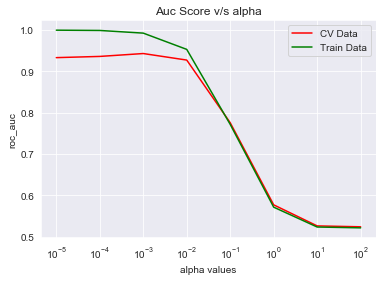

In [72]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(bow_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(bow_train, y_train)
    y_train_pred =  sig_clf.predict_proba(bow_train)[:,1]
    y_cv_pred =  sig_clf.predict_proba(bow_cv)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

### Observation
#### Best C = 0.001
#### ROC = 0.94

In [73]:
optimal_alpha = 0.001

### Testing

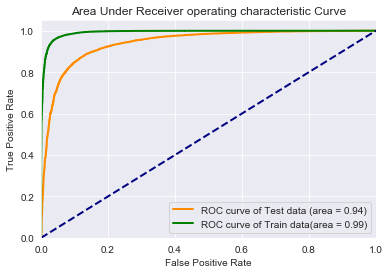

In [79]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(bow_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(bow_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(bow_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(bow_test)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")


#### *ROC Test = 0.94*
#### *ROC Train = 0.99*

### Confusion Matrix

Text(34,0.5,'True Label')

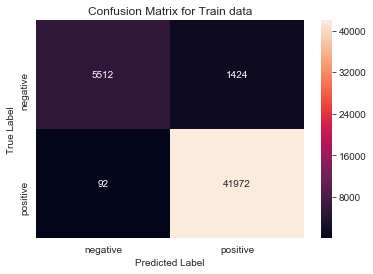

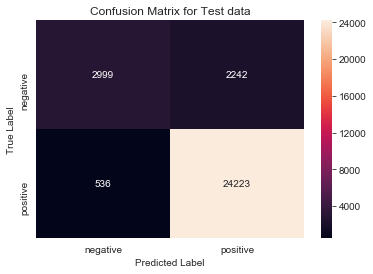

In [80]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(bow_train))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(bow_test))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#### *From the confusion matrix of training set we can say that 5612 points are correctly classified as negative point and 41972 points are correctly classified as positive points. *
#### *From the confusion matrix of testing set we can say that 2999 points are correctly classified as negative point and 24223 points are correctly classified as positive points. *


### Classification Report

In [82]:
prediction=sig_clf.predict(bow_test)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.8146112429352068
micro f1 scoore for data: 0.9074
hamming loss for data: 0.0926
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.85      0.57      0.68      5241
          1       0.92      0.98      0.95     24759

avg / total       0.90      0.91      0.90     30000



### Top 10 positive and negative important features

In [85]:
feature_names = count_vector.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\t\t\tPositive")
print("________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative						Positive
________________________________________________________________________________________________
	-0.7953	worst          				0.5873	delici         
	-0.6648	threw          				0.5629	wont disappoint
	-0.6648	aw             				0.5180	excel          
	-0.6607	terribl        				0.5017	high recommend 
	-0.6526	disappoint     				0.4731	amaz           
	-0.6281	horribl        				0.4079	best           
	-0.5425	disgust        				0.4079	awesom         
	-0.5343	return         				0.3916	great          
	-0.5302	wont buy       				0.3548	perfect        
	-0.5302	refund         				0.3345	easi           


### Linear SVM on TFIDF (Training)

In [176]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(tf_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.9490821207164033  and for train data auc score is -->  0.9935405660205594
0.0001  for CV data auc score is -->  0.9489457605407936  and for train data auc score is -->  0.9706961851233009
0.001  for CV data auc score is -->  0.9445632007743809  and for train data auc score is -->  0.9615582038058774
0.01  for CV data auc score is -->  0.9448059387055836  and for train data auc score is -->  0.9616330506202886
0.1  for CV data auc score is -->  0.6319819498715931  and for train data auc score is -->  0.6277282704105964
1  for CV data auc score is -->  0.6319809310514954  and for train data auc score is -->  0.6277271016253367
10  for CV data auc score is -->  0.6319809310514954  and for train data auc score is -->  0.6277271016253367
100  for CV data auc score is -->  0.6319809310514954  and for train data auc score is -->  0.6277271016253367

 Best C Value 1e-05 with highest roc_auc Score is 0.9490821207164033


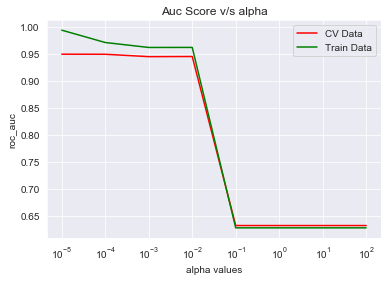

In [177]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(tf_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tf_train, y_train)
    y_train_pred =  sig_clf.predict_proba(tf_train)[:,1]
    y_cv_pred =  sig_clf.predict_proba(tf_cv)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

### Observation
#### Optimal Alpha = 1e-05
#### ROC = 0.94

In [178]:
optimal_alpha = 1e-05

### Testing

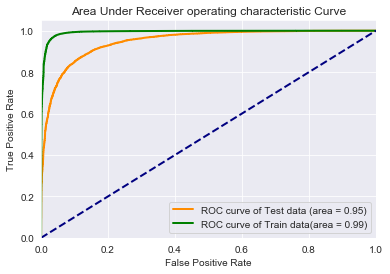

In [179]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(tf_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tf_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(tf_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(tf_test)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

#### *ROC test = 0.95*
#### *ROC train = 0.99*

### Confusion Matrix

Text(34,0.5,'True Label')

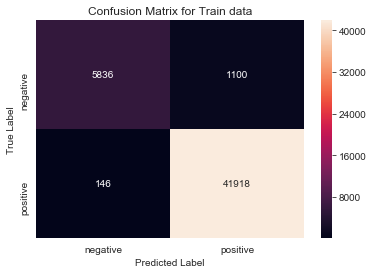

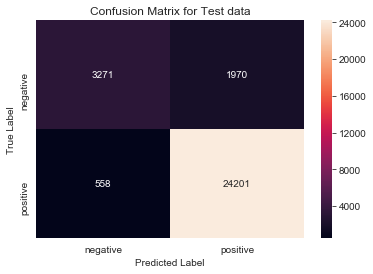

In [180]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(tf_train))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(tf_test))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#### *From the confusion matrix of training set we can say that 5836 points are correctly classified as negative point and 41918 points are correctly classified as positive points. *
#### *From the confusion matrix of training set we can say that 3271 points are correctly classified as negative point and 24201 points are correctly classified as positive points. *


### Classification Report

In [181]:
prediction=sig_clf.predict(tf_test)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.83582109261669
micro f1 scoore for data: 0.9157333333333333
hamming loss for data: 0.08426666666666667
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.85      0.62      0.72      5241
          1       0.92      0.98      0.95     24759

avg / total       0.91      0.92      0.91     30000



### Top 10 important features

In [182]:
feature_names = tfidf_vec.get_feature_names()
coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-(10 + 1):-1])
print("\t\t\tNegative\t\t\t\t\t\tPositive")
print("________________________________________________________________________________________________")
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

			Negative						Positive
________________________________________________________________________________________________
	-6.2472	worst          				7.0301	delici         
	-5.7824	disappoint     				6.5379	great          
	-5.2325	aw             				5.7695	best           
	-5.2262	terribl        				5.4636	excel          
	-5.1699	threw          				5.1567	love           
	-4.6940	two star       				5.1081	high recommend 
	-4.5153	disgust        				4.7887	wont disappoint
	-4.4903	refund         				4.7755	amaz           
	-4.4665	horribl        				4.7043	perfect        
	-4.3591	return         				4.5490	awesom         


### Linear SVM on AvgW2V (Training)

In [96]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(sent_vectors_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.8699665516510415  and for train data auc score is -->  0.8651348423098235
0.0001  for CV data auc score is -->  0.8843209829265803  and for train data auc score is -->  0.8776548940034475
0.001  for CV data auc score is -->  0.8955842655105981  and for train data auc score is -->  0.8916339118882064
0.01  for CV data auc score is -->  0.8947373510897397  and for train data auc score is -->  0.890798826816543
0.1  for CV data auc score is -->  0.8945180136772879  and for train data auc score is -->  0.8905621940730288
1  for CV data auc score is -->  0.8949419883836397  and for train data auc score is -->  0.8911629428414242
10  for CV data auc score is -->  0.7516125981536134  and for train data auc score is -->  0.753696713537629
100  for CV data auc score is -->  0.6310338164826204  and for train data auc score is -->  0.6421527257251322

 Best C Value 0.001 with highest roc_auc Score is 0.8955842655105981


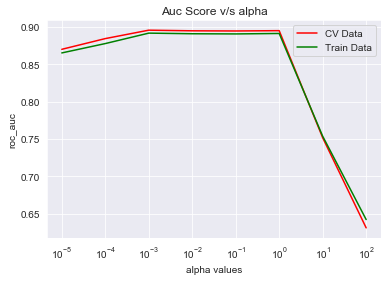

In [97]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(sent_vectors_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(sent_vectors_train, y_train)
    y_train_pred =  sig_clf.predict_proba(sent_vectors_train)[:,1]
    y_cv_pred =  sig_clf.predict_proba(sent_vectors_cv)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

#### Optimal C = 0.01
#### ROC  = 0.89


In [98]:
optimal_alpha= 0.01

### Testing

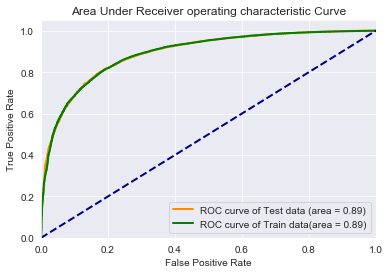

In [99]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(sent_vectors_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(sent_vectors_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(sent_vectors_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(sent_vectors_test)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

####  *ROC test = 0.89*
#### *ROC train = 0.89*

### Confusion Matrix

Text(34,0.5,'True Label')

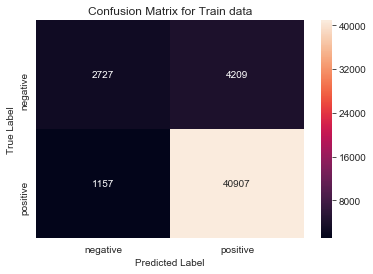

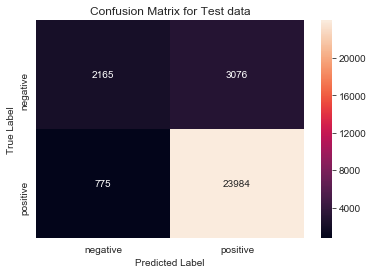

In [100]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(sent_vectors_train))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(sent_vectors_test))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#### *From the confusion matrix of training set we can say that 2727 points are correctly classified as negative point and 40907 points are correctly classified as positive points. *
#### *From the confusion matrix of testing set we can say that 2165 points are correctly classified as negative point and 23984 points are correctly classified as positive points. *


### Classification Report

In [101]:
prediction=sig_clf.predict(sent_vectors_test)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.7274793896469611
micro f1 scoore for data: 0.8716333333333334
hamming loss for data: 0.12836666666666666
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.74      0.41      0.53      5241
          1       0.89      0.97      0.93     24759

avg / total       0.86      0.87      0.86     30000



### Linear SVM on TFIDF-W2V (Training)

In [103]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

clf = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000, tol=1e-3, class_weight='balanced',random_state=0)
tscv = TimeSeriesSplit(n_splits=5)
clf_svm = CalibratedClassifierCV(base_estimator=clf, cv=tscv, method='sigmoid')
clf_svm.fit(tfw2v_train, y_train)

CalibratedClassifierCV(base_estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=0.001, verbose=0, warm_start=False),
            cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
            method='sigmoid')

1e-05  for CV data auc score is -->  0.8266205756766954  and for train data auc score is -->  0.8225960493330754
0.0001  for CV data auc score is -->  0.8448866777725605  and for train data auc score is -->  0.8421724072462986
0.001  for CV data auc score is -->  0.8618529918282866  and for train data auc score is -->  0.8616993814116612
0.01  for CV data auc score is -->  0.8621885232471136  and for train data auc score is -->  0.8629845893367079
0.1  for CV data auc score is -->  0.8611802956441268  and for train data auc score is -->  0.861885842077081
1  for CV data auc score is -->  0.8629148287745068  and for train data auc score is -->  0.8636424166415497
10  for CV data auc score is -->  0.7649030901557463  and for train data auc score is -->  0.7678934682329513
100  for CV data auc score is -->  0.6100944113092523  and for train data auc score is -->  0.6219120556340139

 Best C Value 1 with highest roc_auc Score is 0.8629148287745068


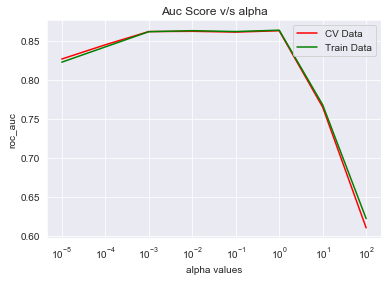

In [104]:
# Linear kernel using SGDClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import roc_auc_score, auc
from sklearn.model_selection import TimeSeriesSplit

best_alpha=0
max_roc_auc=-1
cv_auc = []
train_auc = []
alpha = [10 ** x for x in range(-5, 3)]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(tfw2v_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(tfw2v_train, y_train)
    y_train_pred =  sig_clf.predict_proba(tfw2v_train)[:,1]
    y_cv_pred =  sig_clf.predict_proba(tfw2v_cv)[:,1]
    auc_score_cv = roc_auc_score(y_cv,y_cv_pred)
    auc_score_train = roc_auc_score(y_train,y_train_pred)
    print(i," for CV data auc score is --> ",auc_score_cv," and for train data auc score is --> ",auc_score_train)
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))
    if(max_roc_auc<auc_score_cv):
        max_roc_auc=auc_score_cv
        best_alpha=i

print(f"\n Best C Value {best_alpha} with highest roc_auc Score is {max_roc_auc}")
sns.set_style("darkgrid")
plt.xscale('log')
plt.plot(alpha, cv_auc,'r-', label = 'CV Data')
plt.plot(alpha,train_auc,'g-', label ='Train Data')
plt.legend(loc='upper right')
plt.title(r'Auc Score v/s alpha')
plt.xlabel(r"alpha values",fontsize=10)
plt.ylabel("roc_auc",fontsize=10)
plt.show()

#### Optimal C = 1
#### ROC = .86

In [105]:
optimal_alpha= 1

### Testing

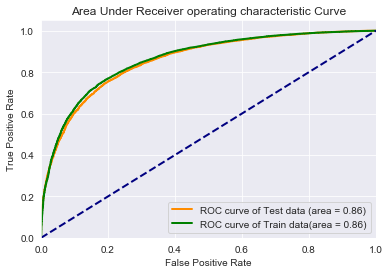

In [106]:
### ROC_AUC CURVE
clf = SGDClassifier(alpha=optimal_alpha, penalty='l2', loss='hinge', random_state=42)
clf.fit(tfw2v_train,y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(tfw2v_train, y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, sig_clf.predict_proba(tfw2v_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, sig_clf.predict_proba(tfw2v_test)[:,1])

# Compute area under roc curve
area_train = auc(train_fpr, train_tpr)
area_test = auc(test_fpr, test_tpr)

lw =2
plt.plot(test_fpr, test_tpr, color='darkorange',lw=lw, label='ROC curve of Test data (area = %0.2f)' % area_test)
plt.plot(train_fpr, train_tpr, color='green',lw=lw, label='ROC curve of Train data(area = %0.2f)' % area_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under Receiver operating characteristic Curve')
plt.legend(loc="lower right")

#### ROC Test = .86
#### ROC train = .86

### Confusion Matrix

Text(34,0.5,'True Label')

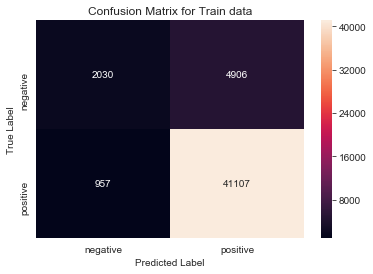

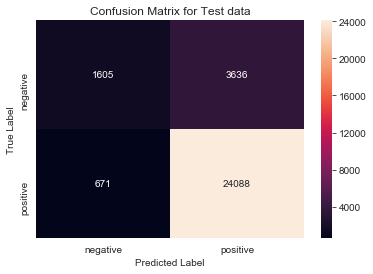

In [107]:
### Confusion Matrix
#Confusion matrix for train data
from sklearn.metrics import confusion_matrix    
plt.figure()
cm = confusion_matrix(y_train, sig_clf.predict(tfw2v_train))
class_label = ["negative", "positive"]
df_cm_train = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_train , annot = True, fmt = "d")
plt.title("Confusion Matrix for Train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#Confusion matrix for test data
plt.figure()
cm = confusion_matrix(y_test, sig_clf.predict(tfw2v_test))
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

#### *From the confusion matrix of training set we can say that 2030 points are correctly classified as negative point and 41107 points are correctly classified as positive points. *
#### *From the confusion matrix of training set we can say that 1605 points are correctly classified as negative point and 24088 points are correctly classified as positive points. *


### Classification Report

In [108]:
prediction=sig_clf.predict(sent_vectors_test)
print("macro f1 score for data :",metrics.f1_score(y_test, prediction, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, prediction, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,prediction))
print("Precision recall report for data:\n",metrics.classification_report(y_test, prediction))

macro f1 score for data : 0.6645265142813482
micro f1 scoore for data: 0.8613333333333333
hamming loss for data: 0.13866666666666666
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.80      0.27      0.41      5241
          1       0.86      0.99      0.92     24759

avg / total       0.85      0.86      0.83     30000



### RBF SVC ON BOW (Training)

In [110]:
#data splitting for RBF kernel
y_train=final_sorted_time['Score'][0:13000]
y_cv=final_sorted_time['Score'][13000:16000]
y_test=final_sorted_time['Score'][16000:20000]

In [111]:
X_train=final_sorted_time['CleanedText'][0:13000]
X_cv=final_sorted_time['CleanedText'][13000:16000]
X_test=final_sorted_time['CleanedText'][16000:20000]

In [112]:
print(X_train.shape, "   ", y_train.shape)
print(X_cv.shape, "   ", y_cv.shape)
print(X_test.shape, "   ", y_test.shape)

(13000,)     (13000,)
(3000,)     (3000,)
(4000,)     (4000,)


In [113]:
cnt_vec = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
bow_train = cnt_vec.fit_transform(X_train)
bow_cv  = cnt_vec.transform(X_cv)
bow_test = cnt_vec.transform(X_test)

In [114]:
print(bow_train.shape)
print(bow_cv.shape)
print(bow_test.shape)


(13000, 300)
(3000, 300)
(4000, 300)


------------------------------ AUC Score for train data ------------------------------


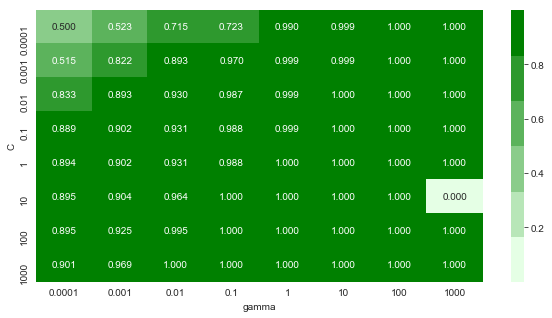

------------------------------ AUC Score for CV data ------------------------------


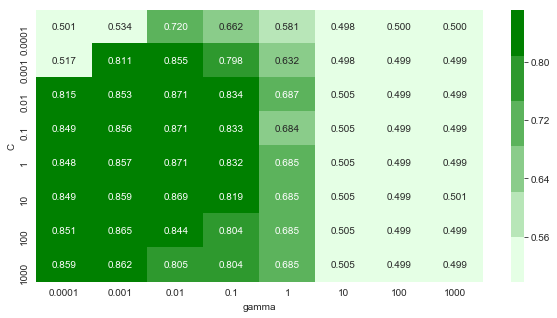

In [115]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(bow_train,y_train)
        probs = clf.predict_proba(bow_cv)
        prob = clf.predict_proba(bow_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

#### Optimal C = 0.01
#### Gamma = 0.1

### Testing

AUC Score 0.8395322200813531
macro f1 score for data : 0.6312032999556825
micro f1 scoore for data: 0.881
hamming loss for data: 0.119
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.69      0.21      0.33       540
          1       0.89      0.98      0.93      3460

avg / total       0.86      0.88      0.85      4000



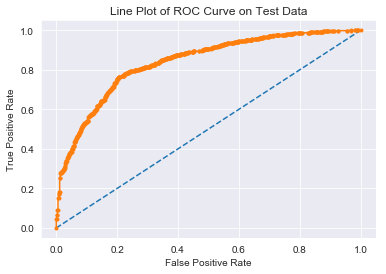

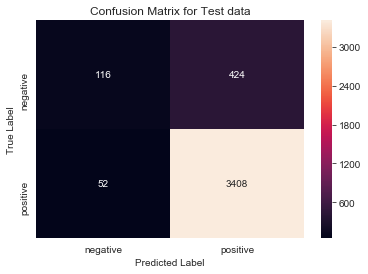

In [123]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=0.01,kernel='rbf',probability=True,gamma=0.1)
clf.fit(bow_train,y_train)
prob = clf.predict_proba(bow_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


#### AUC Score = 0.83
#### *From the confusion matrix of test set we can say that 116 points are correctly classified as negative point and 3408 points are correctly classified as positive points. *



### RBF SVC ON TFIDF (Training)

In [127]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=300)
tf_train = tfidf_vec.fit_transform(X_train)
tf_cv  = tfidf_vec.transform(X_cv)
tf_test = tfidf_vec.transform(X_test)

In [128]:
print(tf_train.shape)
print(tf_cv.shape)
print(tf_test.shape)

(13000, 300)
(3000, 300)
(4000, 300)


------------------------------ AUC Score for train data ------------------------------


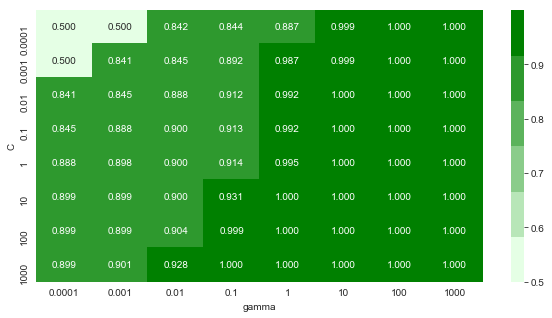

------------------------------ AUC Score for CV data ------------------------------


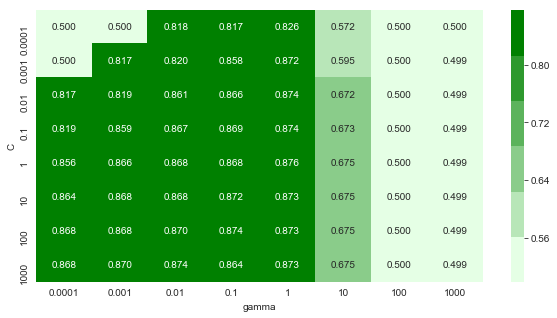

In [129]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(tf_train,y_train)
        probs = clf.predict_proba(tf_cv)
        prob = clf.predict_proba(tf_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

#### Optimal C = 1
#### Gamma = 1

### Testing

AUC Score 0.8861244915435667
macro f1 score for data : 0.7038735602811529
micro f1 scoore for data: 0.89375
hamming loss for data: 0.10625
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.72      0.34      0.47       540
          1       0.91      0.98      0.94      3460

avg / total       0.88      0.89      0.88      4000



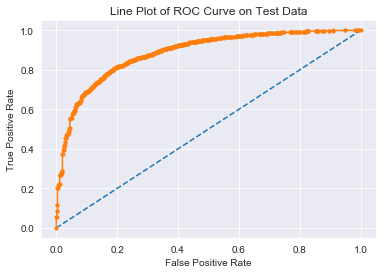

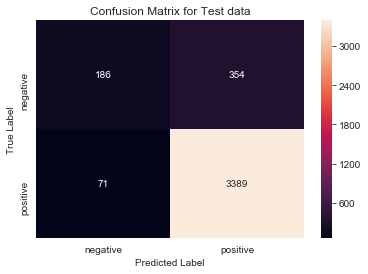

In [139]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=1,kernel='rbf',probability=True,gamma=1)
clf.fit(tf_train,y_train)
prob = clf.predict_proba(tf_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


#### AUC Score = 0.83
#### *From the confusion matrix of test set we can say that 186 points are correctly classified as negative point and 3389 points are correctly classified as positive points. *



### RBF-SVC on AVG-W2V (Training)

In [154]:
avg_w2v = np.array(sent_vectors_train)
avg_w2v.shape

(49000, 50)

In [155]:
avgw2v_train = avg_w2v[0:13000]
avgw2v_cv = avg_w2v[13000:16000]
avgw2v_test = avg_w2v[16000:20000]

In [156]:
avgw2v_train.shape

(13000, 50)

In [157]:
y_train.shape

(13000,)

------------------------------ AUC Score for train data ------------------------------


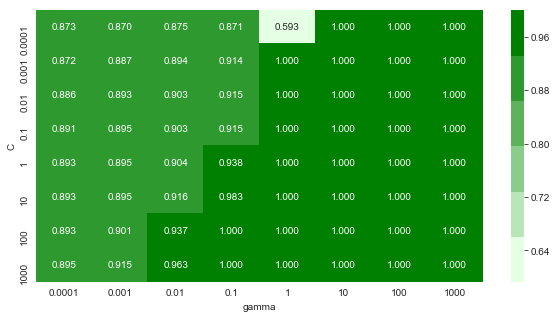

------------------------------ AUC Score for CV data ------------------------------


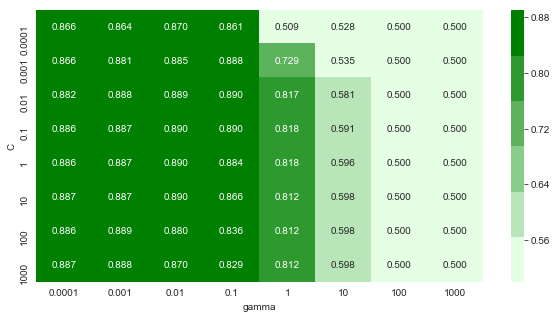

In [134]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(avgw2v_train,y_train)
        probs = clf.predict_proba(avgw2v_cv)
        prob = clf.predict_proba(avgw2v_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

#### Optimal C=1
#### Gamma = 1

AUC Score 0.8461520552344253
macro f1 score for data : 0.6462299516775329
micro f1 scoore for data: 0.88425
hamming loss for data: 0.11575
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.72      0.24      0.36       540
          1       0.89      0.99      0.94      3460

avg / total       0.87      0.88      0.86      4000



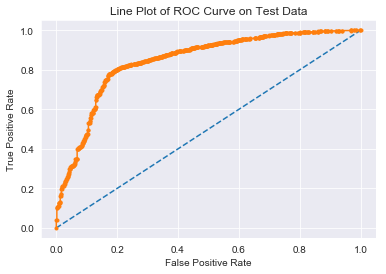

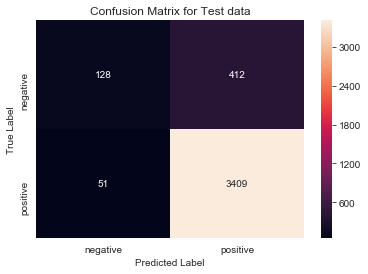

In [158]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=1,kernel='rbf',probability=True,gamma=1)
clf.fit(avgw2v_train,y_train)
prob = clf.predict_proba(avgw2v_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


#### AUC Score = 0.84
#### *From the confusion matrix of test set we can say that 128 points are correctly classified as negative point and 3409 points are correctly classified as positive points. *



### RBF SVC ON TFIDF-W2V (Training)

In [149]:
tfw2v_train.shape

(49000, 50)

In [161]:
tfrbf_train = tfw2v_train[0:13000]
tfrbf_cv = tfw2v_train[13000:16000]
tfrbf_test = tfw2v_train[16000:20000]

In [162]:
y_train.shape

(13000,)

------------------------------ AUC Score for train data ------------------------------


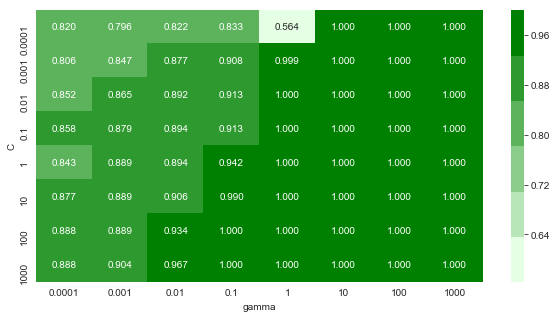

------------------------------ AUC Score for CV data ------------------------------


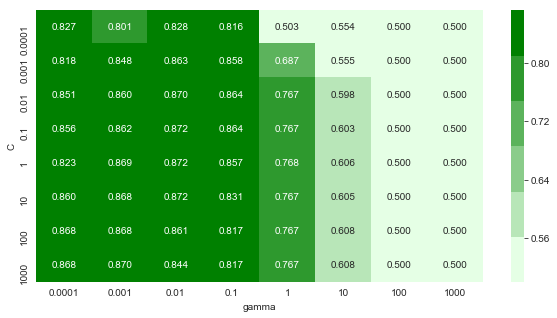

In [138]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# SVM with kernel = 'rbf'
pred_cv = []
pred_train = []
C = [10 ** x for x in range(-4, 4)]
gamma = [10** x for x in range(-4,4)]
for i in C:
    for j in gamma:
        clf = SVC(kernel='rbf',probability=True,C=i,gamma=j)
        clf.fit(tfrbf_train,y_train)
        probs = clf.predict_proba(tfrbf_cv)
        prob = clf.predict_proba(tfrbf_train)
        probs = probs[:,1]
        prob = prob[:,1]
        auc_score_cv = roc_auc_score(y_cv,probs)
        auc_score_train = roc_auc_score(y_train,prob)
        pred_cv.append(auc_score_cv)
        pred_train.append(auc_score_train)
cmap=sns.light_palette("green")
# representing heat map for auc score
print("-"*30, "AUC Score for train data", "-"*30)
pred_train = np.array(pred_train)
pred_train = pred_train.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_train,annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma,yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()
print("-"*30, "AUC Score for CV data", "-"*30)
pred_cv = np.array(pred_cv)
pred_cv = pred_cv.reshape(len(C),len(gamma))
plt.figure(figsize=(10,5))
sns.heatmap(pred_cv, annot=True, cmap=cmap, fmt=".3f", xticklabels=gamma, yticklabels=C)
plt.xlabel('gamma')
plt.ylabel('C')
plt.show()

#### Optimal C=1
#### gamma = 0.1

AUC Score 0.8639375936630271
macro f1 score for data : 0.6885396303920464
micro f1 scoore for data: 0.8907499999999999
hamming loss for data: 0.10925
Precision recall report for data:
              precision    recall  f1-score   support

          0       0.72      0.31      0.44       540
          1       0.90      0.98      0.94      3460

avg / total       0.88      0.89      0.87      4000



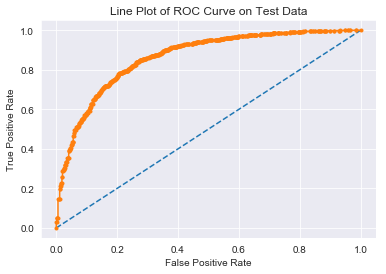

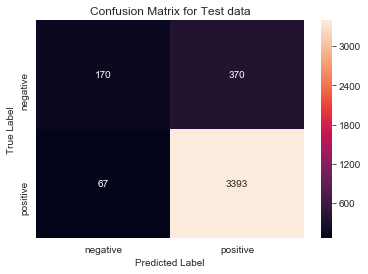

In [163]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix    
clf = SVC(C=1,kernel='rbf',probability=True,gamma=0.1)
clf.fit(tfrbf_train,y_train)
prob = clf.predict_proba(tfrbf_test) 
# keep probabilities for the positive outcome only
probs = prob[:, 1]
print("AUC Score",roc_auc_score(y_test,probs))
# plot roc curve
fpr, tpr, thresholds = roc_curve(y_test,probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title("Line Plot of ROC Curve on Test Data")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')    
plt.show
predicted =np.argmax(prob,axis=1)
plt.figure()
cm = confusion_matrix(y_test,predicted)
class_label = ["negative", "positive"]
df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm_test , annot = True, fmt = "d")
plt.title("Confusion Matrix for Test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
print("macro f1 score for data :",metrics.f1_score(y_test, predicted, average = 'macro'))
print("micro f1 scoore for data:",metrics.f1_score(y_test, predicted, average = 'micro'))
print("hamming loss for data:",metrics.hamming_loss(y_test,predicted))
print("Precision recall report for data:\n",metrics.classification_report(y_test, predicted))


#### AUC Score = 0.86
#### *From the confusion matrix of test set we can say that 170 points are correctly classified as negative point and 3393 points are correctly classified as positive points. *



### Conclusion

In [184]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","Liner kernel",0.001,0.94])
x.add_row(["Tf-Idf","Liner kernel",1e-05,0.95])
x.add_row(["Avg-W2V","Liner kernel",0.01,0.89])
x.add_row(["TfIdf-W2V","Liner kernel",1,0.86])

y = PrettyTable()
y.field_names = ["Vectorizer", "Model", "Best Hyper Parameter(C & gamma)","Test Auc Score"]
y.add_row(["BoW","RBF kernel",(0.01,0.1),0.83])
y.add_row(["Tf-Idf","RBF kernel",(1,1),0.84])
y.add_row(["Avg-W2V","RBF kernel",(1,1),0.84])
y.add_row(["TfIdf-W2V","RBF kernel",(1,0.1),0.86])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)
print(y)

****Final Conclusion:****

+------------+--------------+-------------------------+----------------+
| Vectorizer |    Model     | Best Hyper Parameter(C) | Test Auc Score |
+------------+--------------+-------------------------+----------------+
|    BoW     | Liner kernel |          0.001          |      0.94      |
|   Tf-Idf   | Liner kernel |          1e-05          |      0.95      |
|  Avg-W2V   | Liner kernel |           0.01          |      0.89      |
| TfIdf-W2V  | Liner kernel |            1            |      0.86      |
+------------+--------------+-------------------------+----------------+
+------------+------------+---------------------------------+----------------+
| Vectorizer |   Model    | Best Hyper Parameter(C & gamma) | Test Auc Score |
+------------+------------+---------------------------------+----------------+
|    BoW     | RBF kernel |           (0.01, 0.1)           |      0.83      |
|   Tf-Idf   | RBF kernel |              (1, 1)             |      0.84      |
|  Avg-W2V   | RBF ke

#### *The best model seems to be Linear Kernel with TF-idf Vectorization.*
 